#  Segment using Unet++

In [3]:
#Libraries------------------ 
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc
from pathlib import Path
from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import glob
import cv2
from PIL import Image
import glob2
from tensorflow.keras.models import load_model
import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, Conv2DTranspose, 
                                     SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import * 
from tensorflow.keras.applications import ResNet50
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from tensorflow.keras.metrics import MeanIoU

K.clear_session()
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
get_ipython().run_line_magic('matplotlib', 'inline')


# Reding and Preprocessing images

In [4]:
#Load image data-------------------
H,W,CH=[128,128,3]
def cv_load_img(path):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(W,H))
    return img

In [5]:
#Load data---------------------
BASE_DIR="Colonoscopy/train/"
img_path= os.listdir(BASE_DIR+'images')
mask_path= os.listdir(BASE_DIR+'masks')


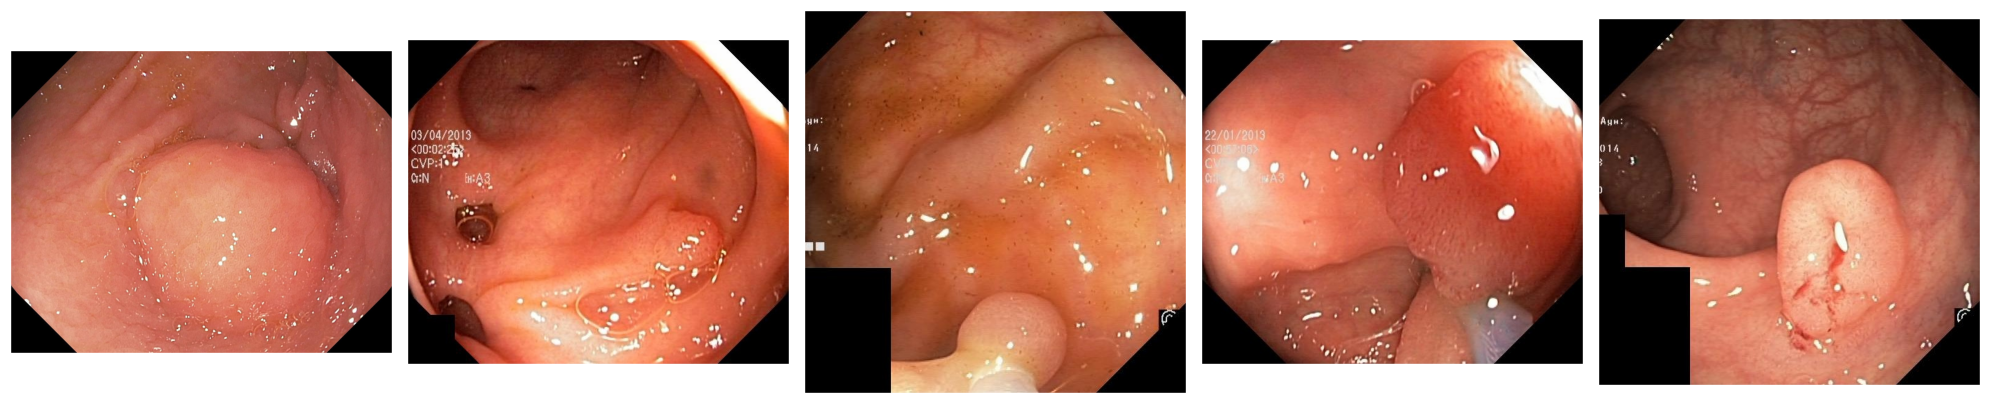

In [6]:
#plot sample images--------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path= BASE_DIR + 'images/'
    ax[i].imshow(load_img(path + img_path[i]))
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()

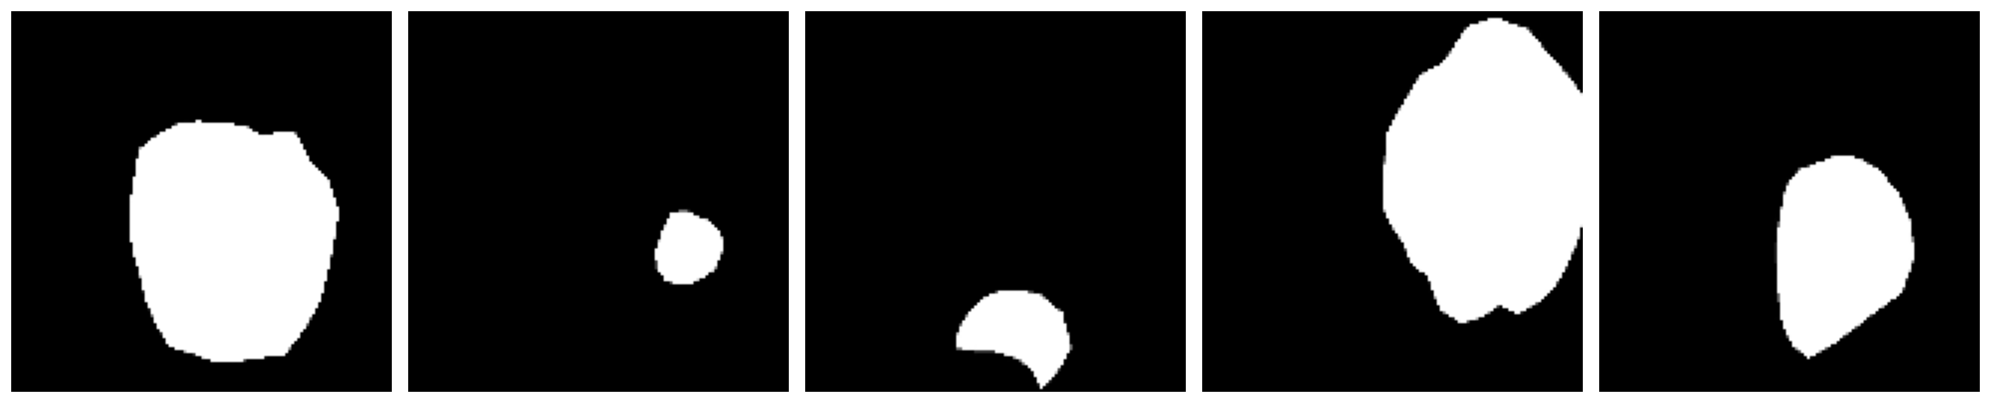

In [7]:
#plot sample masks--------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path= BASE_DIR + 'masks/'
    ax[i].imshow(cv_load_img(path + mask_path[i])[:, :, 0], 'gray')
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()

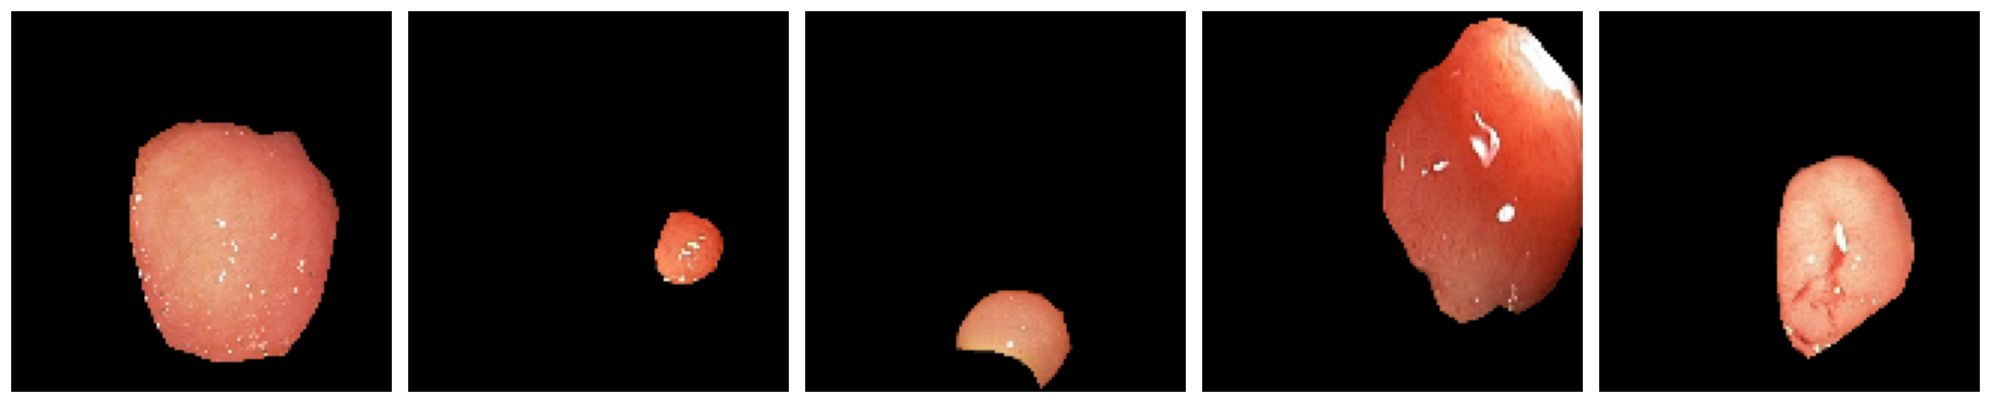

In [8]:
#plot sample images--with blended mask ------------
fig, ax= plt.subplots(1,5, figsize=(20, 10))
for i in range(5):
    path1= BASE_DIR + 'images/'
    ax[i].imshow((cv_load_img(path1 + img_path[i])/255) * (cv_load_img(path + mask_path[i])/255))
    ax[i].set_xticks([]); ax[i].set_yticks([])

fig.tight_layout()
plt.show()

# Augmented Images and Masks

In [9]:
#data  preparation
X_train, X_test, y_train, y_test = train_test_split(img_path, mask_path, test_size=0.2, random_state=22)
len(X_train), len(X_test)

(800, 200)

In [10]:
#batch generation-----------------------
def load_data(path_list, gray=False):
    data=[]
    for path in tqdm(path_list):
        img= cv_load_img(path)
        if gray:
            img= img[:, :, 0:1]
        img= cv2.resize(img, (W, H))
        data.append(img)
    return np.array(data)


In [11]:
#train data generation---------------------
X_train= load_data([BASE_DIR + 'images/' + x for x in X_train])/255.0
X_test= load_data([BASE_DIR + 'images/' + x for x in X_test])/255.0


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
##test data generation---------------------
Y_train= load_data([BASE_DIR + 'masks/' + x for x in y_train], gray=True)/255.0
Y_test= load_data([BASE_DIR + 'masks/' + x for x in y_test], gray=True)/255.0
Y_train= Y_train.reshape(-1, W, H, 1)
Y_test= Y_test.reshape(-1, W, H, 1)

Y_train.shape, Y_test.shape


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

((800, 128, 128, 1), (200, 128, 128, 1))

 # Unet Model 

In [13]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    
    return model

In [38]:
def dice_loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true * y_true) + tf.reduce_sum(y_pred * y_pred) - tf.reduce_sum(y_true * y_pred)

    return 1 - numerator / denominator

In [14]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [40]:
metrics=['accuracy', jacard_coef]

inputs = tf.keras.layers.Input((H, W, CH))
model = GiveMeUnet(inputs, droupouts= 0.07)
model.compile(optimizer = 'Adam', loss =  dice_loss, metrics =metrics)#loss = binary_crossentropy

# Model Summary

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 128, 128, 16  64         ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 conv2d_46 (Conv2D)             (None, 8, 8, 256)    295168      ['dropout_19[0][0]']             
                                                                                                  
 batch_normalization_44 (BatchN  (None, 8, 8, 256)   1024        ['conv2d_46[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 8, 8, 256)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 8, 8, 256)    590080      ['activation_44[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 concatenate_11 (Concatenate)   (None, 128, 128, 32  0           ['conv2d_transpose_11[0][0]',    
                                )                                 'activation_37[0][0]']          
                                                                                                  
 dropout_23 (Dropout)           (None, 128, 128, 32  0           ['concatenate_11[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 128, 128, 16  4624        ['dropout_23[0][0]']             
                                )                                                                 
                                                                                                  
 batch_nor

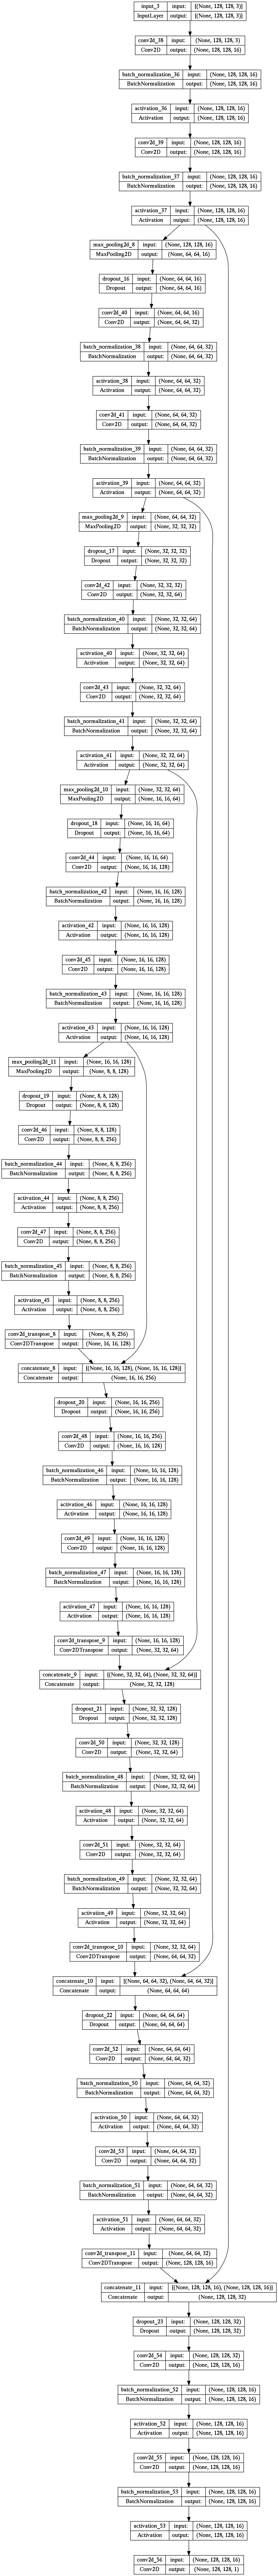

In [41]:
#Summary of model------------------
model.summary()


#Plot of model------------------
dot_img_file = 'model.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)


In [42]:
#Train model---------------------------
nbatch_size=128
nepochs=1
history = model.fit(X_train,Y_train,batch_size=nbatch_size,
                    epochs=nepochs,validation_split=0.2,shuffle=True,
                    max_queue_size=32,workers=4,use_multiprocessing=True,                   
                   )

5/5 [==============================] - 102s 20s/step - loss: 0.7492 - accuracy: 0.5723 - jacard_coef: 0.1525 - val_loss: 0.7517 - val_accuracy: 0.2762 - val_jacard_coef: 0.1578


In [43]:
df_result = pd.DataFrame(history.history)
df_result

,loss,accuracy,jacard_coef,val_loss,val_accuracy,val_jacard_coef
0,0.749201,0.572344,0.15254,0.751695,0.276203,0.157799


# Visualize the model predictions

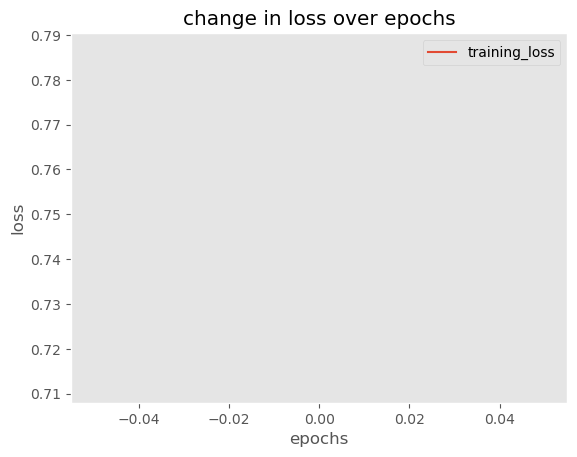

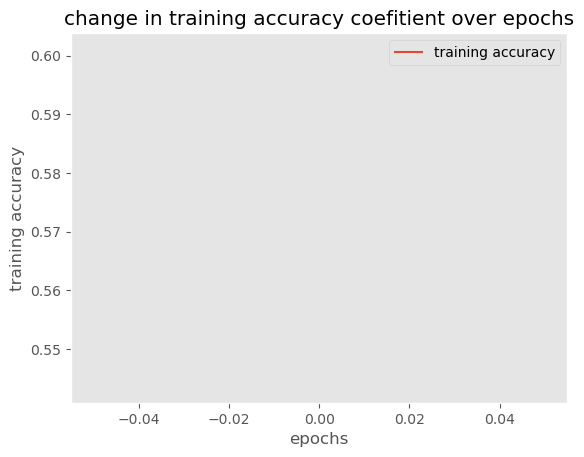

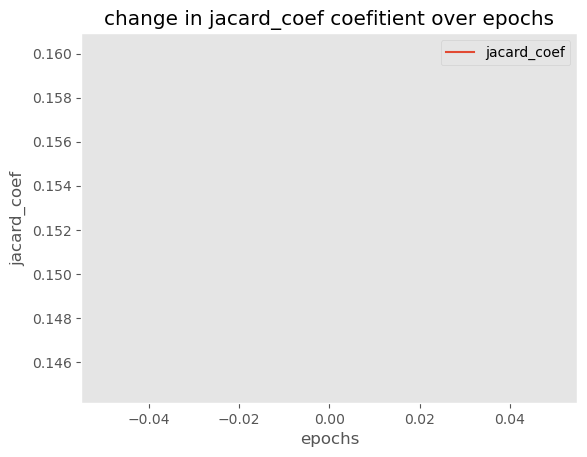

<Figure size 640x480 with 0 Axes>

In [44]:
# Plotting loss change over epochs---------------
nrange=nepochs
x = [i for i in range(nrange)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['training_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.axis('off')
plt.grid(None)
plt.show()
plt.tight_layout()

# Plotting accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['accuracy'])
plt.title('change in training accuracy coefitient over epochs')
plt.legend(['training accuracy'])
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.grid(None)
plt.show()
plt.tight_layout()

# Plotting accuracy change over epochs---------------------
x = [i for i in range(nrange)]
plt.plot(x,history.history['jacard_coef'])
plt.title('change in jacard_coef coefitient over epochs')
plt.legend(['jacard_coef'])
plt.xlabel('epochs')
plt.ylabel('jacard_coef')
plt.grid(None)
plt.show()
plt.tight_layout()

In [45]:
# Creating predictions on our test set-----------------
predictions = model.predict(X_test)

# create predictes mask--------------

def create_mask(predictions,input_shape=(W,H,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask


7/7 [==============================] - 4s 493ms/step


In [46]:
# Ploting results for one image

def plot_results_for_one_sample(sample_index):
    
    mask = create_mask(predictions[sample_index])    
    fig = plt.figure(figsize=(20,20))
    #image
    fig.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(X_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    #mask
    fig.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(Y_test[sample_index])
    plt.axis('off')
    plt.grid(None)
    #Predicted mask
    fig.add_subplot(1,4,3)
    plt.title('Predicted mask')  
    plt.imshow(mask)
    plt.axis('off')
    plt.grid(None)
    #Segment
    fig.add_subplot(1,4,4)
    plt.title("Segment image")
    plt.imshow(X_test[sample_index]*mask)
    plt.grid(None)
    plt.axis('off')  
    fig.tight_layout()
    


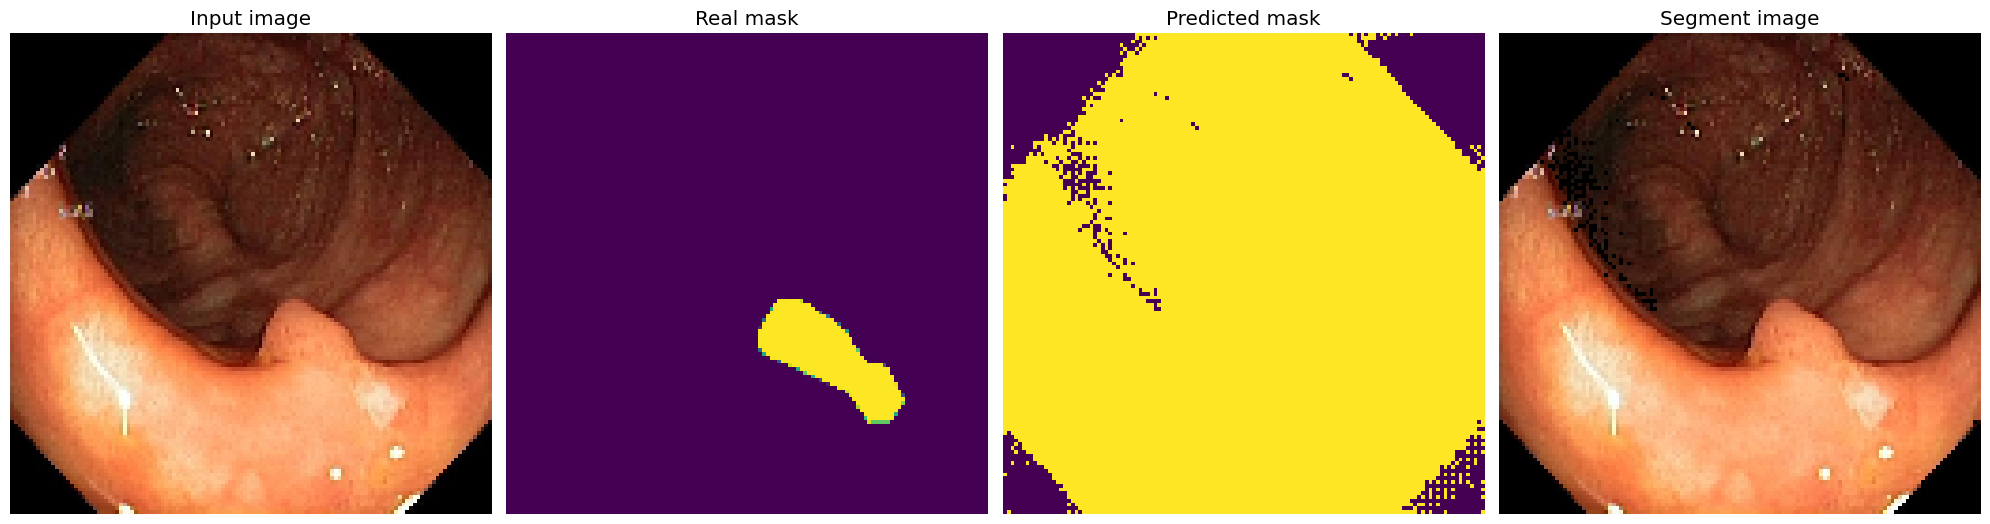

In [47]:
#Show predicted result---------------
plot_results_for_one_sample(0)

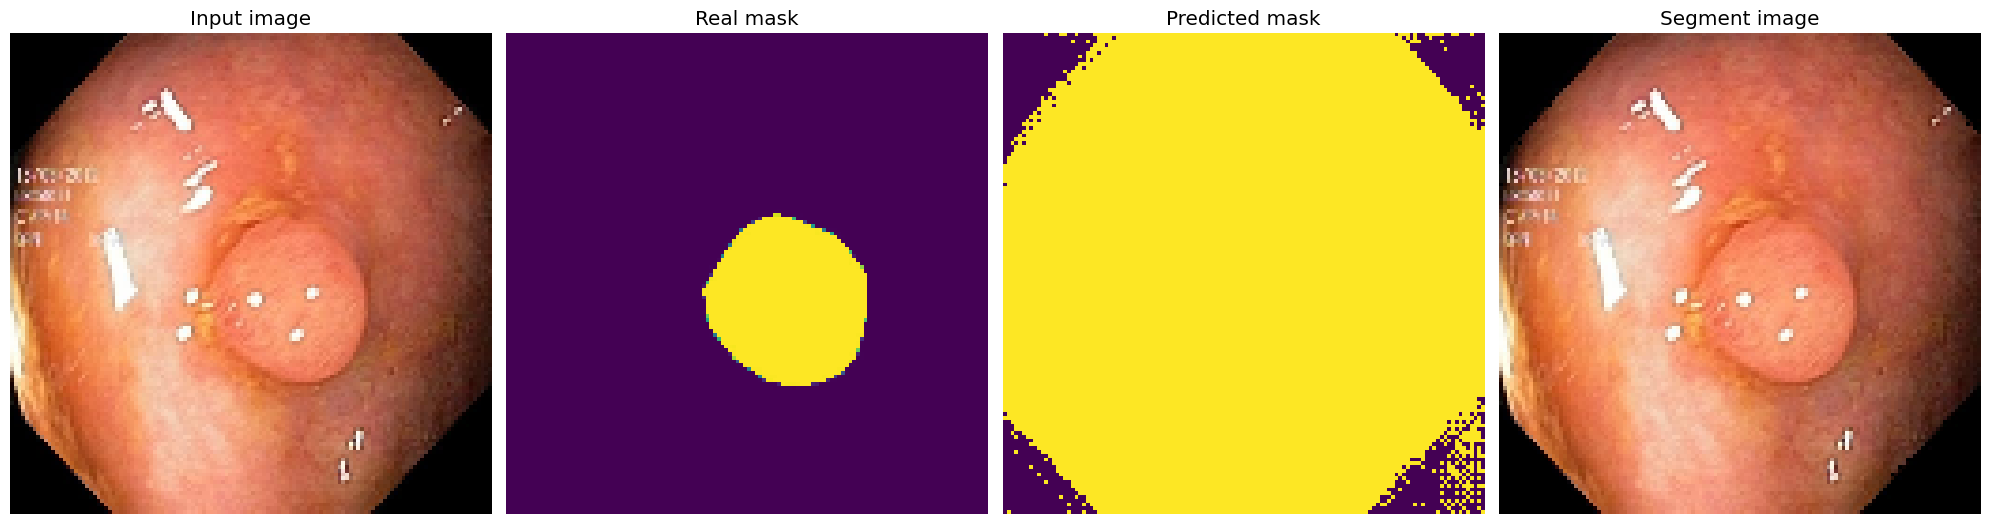

In [48]:
#Show predicted result---------------
plot_results_for_one_sample(1)

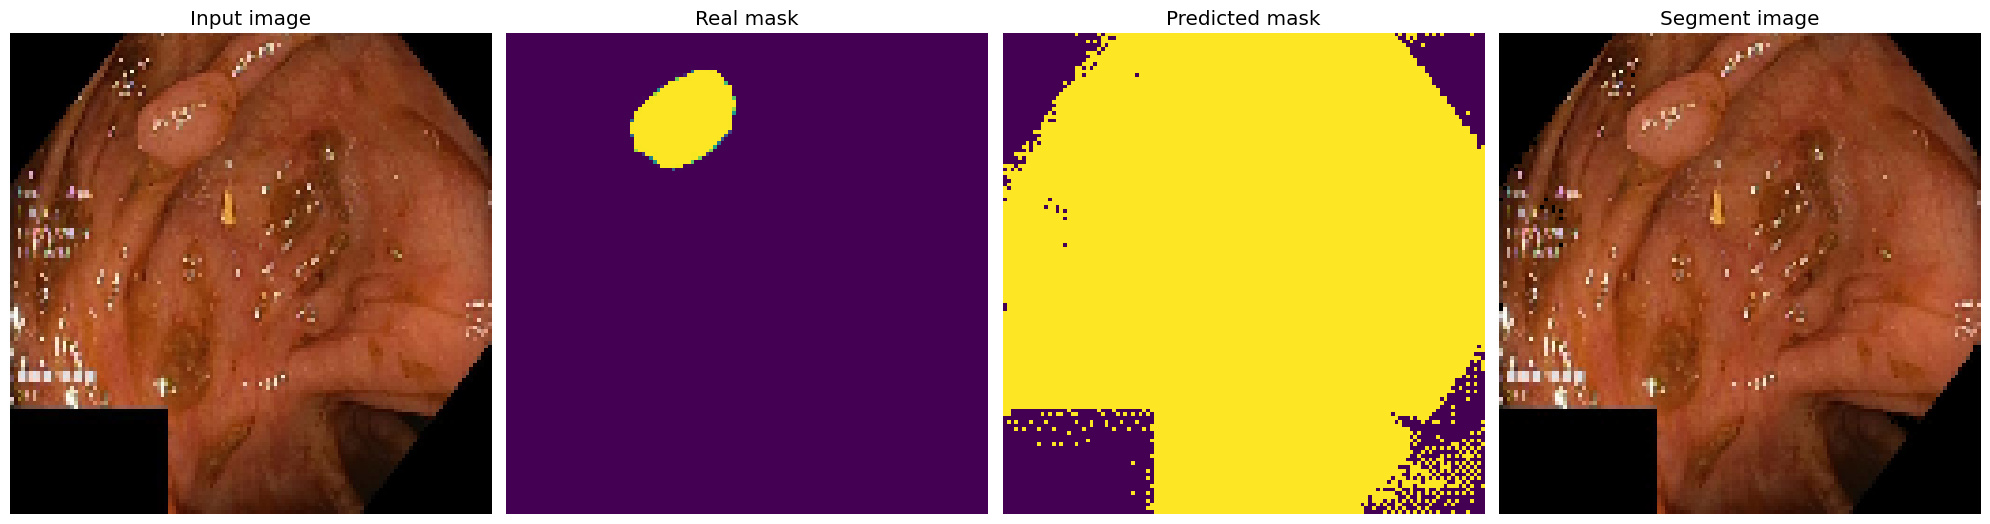

In [49]:
#Show predicted result---------------
plot_results_for_one_sample(2)

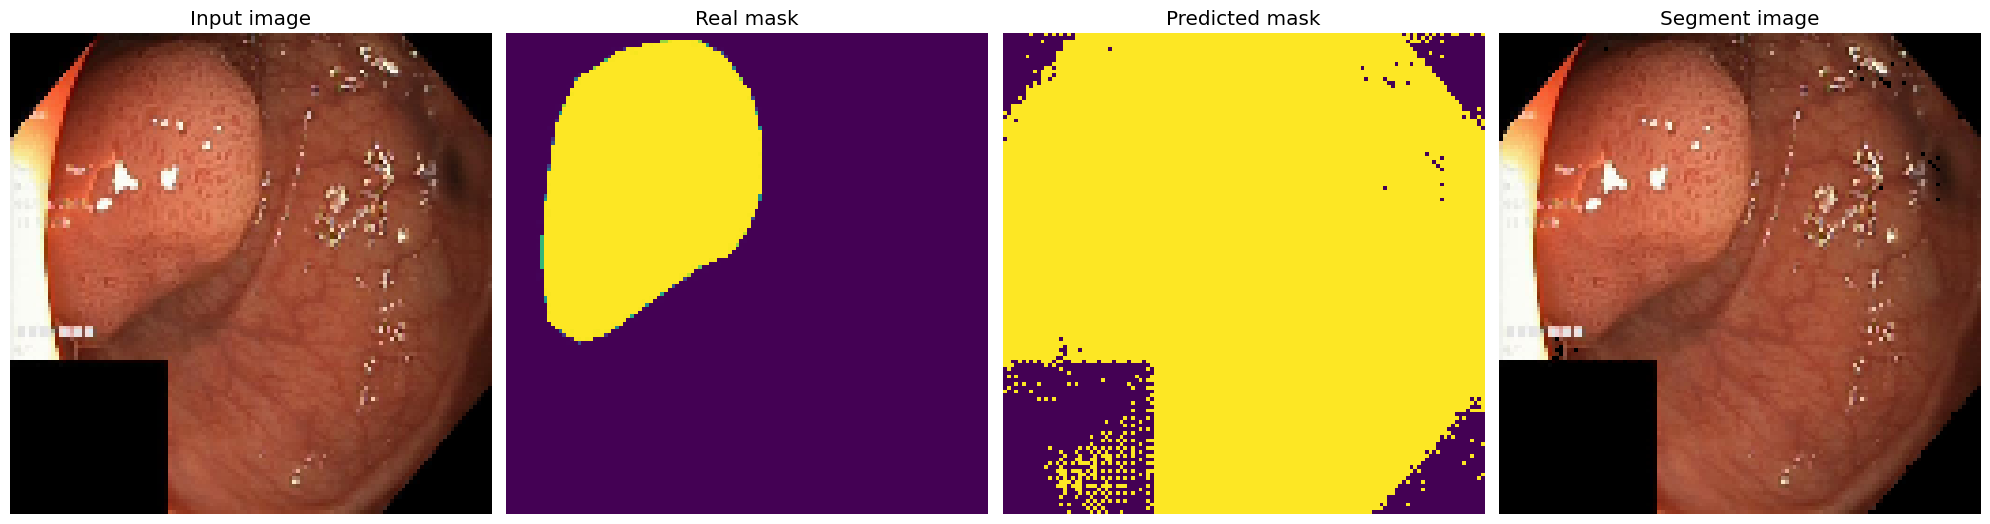

In [50]:
#Show predicted result---------------
plot_results_for_one_sample(3)

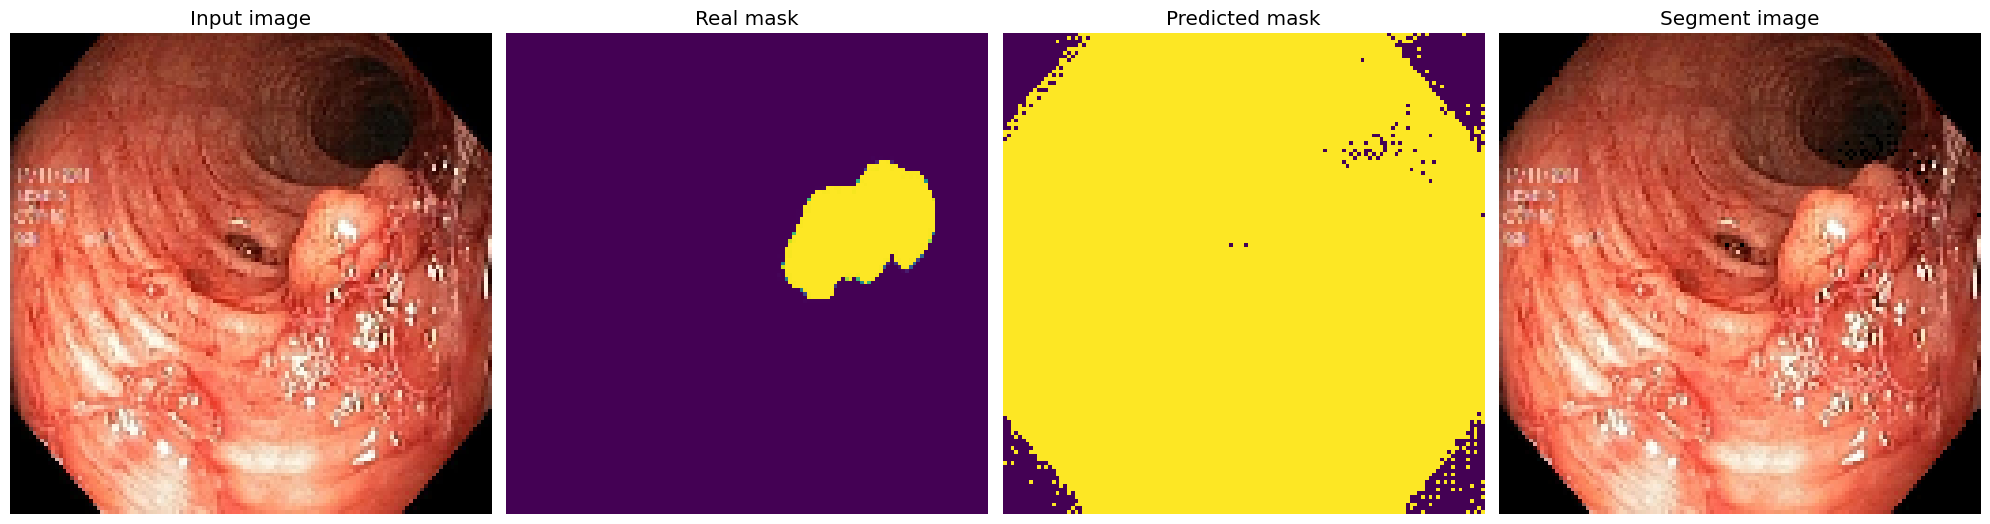

In [51]:
#Show predicted result---------------
plot_results_for_one_sample(4)

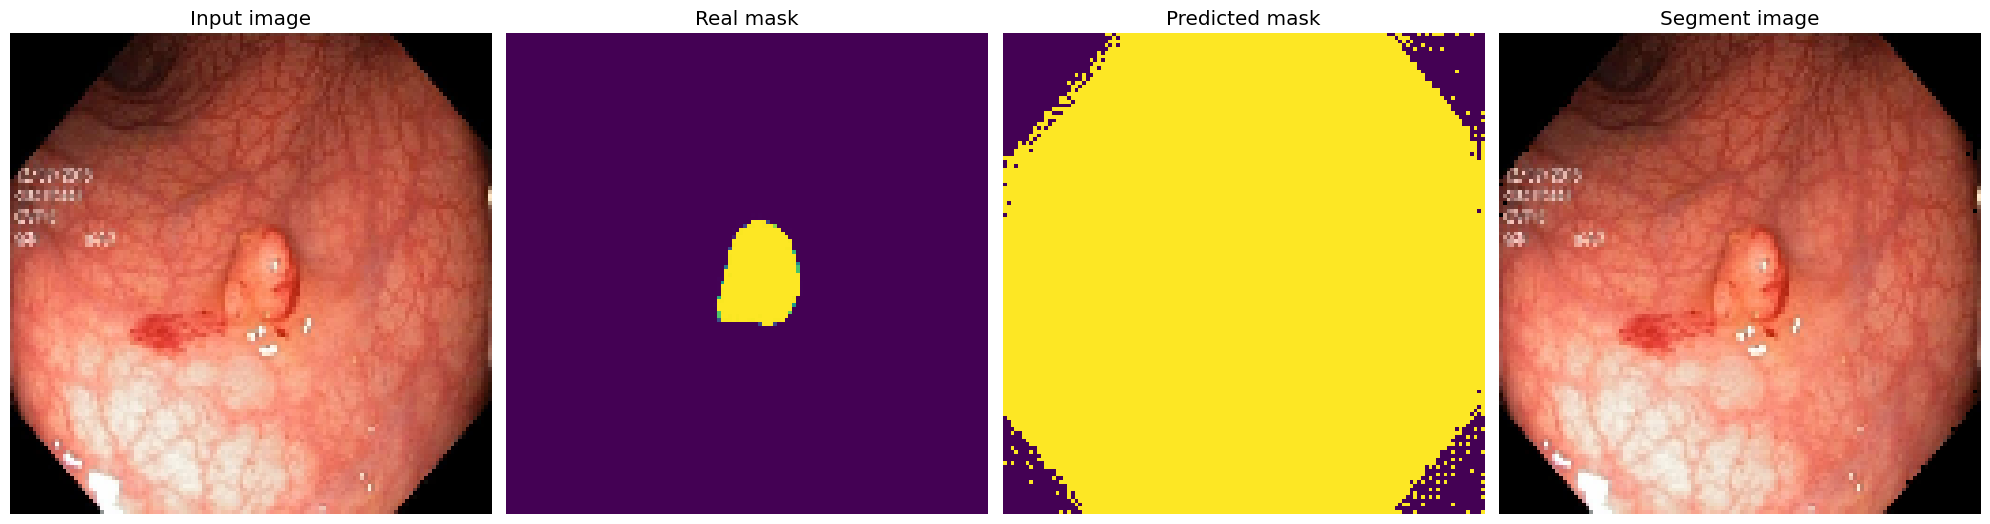

In [52]:
#Show predicted result---------------
plot_results_for_one_sample(12)